In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import pickle

from functions import *
from utils import *
sys.path.append("/model")
from deeplab_plus import *
from deeplabv3 import *
sys.path.append("/import")
from datasets import *
from fog_datasets import *

In [2]:
n_epoch=1

batch_size = 2

lr=1e-3

val_dataset = DatasetTrain(cityscapes_data_path="small_cityscapes",
                         cityscapes_meta_path="small_meta")
                         
fog_dataset = DatasetTrain_fog(cityscapes_data_path="small_cityscapes_foggy")

num_val_batches = int(len(val_dataset)/batch_size)
print ("num_val_batches:", num_val_batches)

dataloader_source = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size, shuffle=False,
num_workers=1)

dataloader_target = torch.utils.data.DataLoader(dataset=fog_dataset,
                                         batch_size=batch_size, shuffle=False,
num_workers=1)
                
network = DeepLab_Plus("eval_val", project_dir="save").cuda()


with open('small_meta/class_weights.pkl', 'rb') as file:
    class_weights = np.array(pickle.load(file))
class_weights = torch.from_numpy(class_weights)
class_weights = Variable(class_weights.type(torch.FloatTensor)).cuda()

# loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(network.parameters(), lr=lr)
loss_dn = torch.nn.NLLLoss()

for p in network.parameters():
    p.requires_grad = True

num_val_batches: 1487
pretrained resnet, 18


In [3]:
print(val_dataset[0][0].shape)
print(fog_dataset[0][0].shape)

torch.Size([3, 512, 1024])
torch.Size([3, 512, 1024])


In [4]:
err_tot=[]
err_s_label_tot=[]
err_t_domain_tot=[]
err_s_domain_tot=[]
for epoch in range(n_epoch):

    len_dataloader = min(len(dataloader_source), len(dataloader_target))
    data_source_iter = iter(dataloader_source)
    data_target_iter = iter(dataloader_target)

    i = 0
    while i < len_dataloader:
        if i>1:
            break
        with torch.no_grad():
            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
        
            # training model using source data
            
            data_source = data_source_iter.next()
            s_img, s_label,s_id = data_source
            print(s_img.shape)
            
            network.zero_grad()
            
            # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
            s_img = Variable(s_img).cuda() # (shape: (batch_size, 3, img_h, img_w))
            s_label = Variable(s_label.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))

            domain_label = torch.zeros(batch_size)
            domain_label = domain_label.long()
            domain_label=Variable(domain_label).cuda()
            

            outputs, domain_output = network(x=s_img,alpha=alpha) # (shape: (batch_size, num_classes, img_h, img_w))
            
            # compute the loss:
            print(outputs.shape)
            print(s_label.shape)
            err_s_label = loss_fn(outputs, s_label)
            
            err_s_domain=loss_dn(domain_output, domain_label)
            
            # training model using target data
            data_target = data_target_iter.next()
            t_img, _ ,t_id= data_target
            
            domain_label = torch.ones(batch_size)
            domain_label = domain_label.long()
        
            input_img = Variable(t_img).cuda()
            domain_label = Variable(domain_label).cuda()
            
            _, domain_output = network(x=t_img, alpha=alpha)
            
            err_t_domain = loss_dn(domain_output, domain_label)
            err = err_t_domain + err_s_domain + err_s_label
            err_tot.append(err)
            err_s_label_tot.append(err_s_label)
            err_t_domain_tot.append(err_t_domain)
            err_s_domain_tot.append(err_s_domain)
            err=Variable(err,requires_grad = True).cuda()
            err.backward()
            optimizer.step()
        
            i += 1
        
            print ('epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
                    % (epoch, i, len_dataloader, err_s_label.cpu().data.numpy(),
        err_s_domain.cpu().data.numpy(), err_t_domain.cpu().data.numpy()))
        
        
    
    


torch.Size([2, 3, 512, 1024])


C:\Users\cleme\Anaconda3\lib\site-packages\torch\nn\functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\cleme\Anaconda3\lib\site-packages\torch\nn\functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([2, 512, 64, 128])
torch.Size([2, 8, 64, 128])
torch.Size([2, 8, 9, 18])
torch.Size([2, 1296])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 20, 512, 1024])
torch.Size([2, 512, 1024])
torch.Size([2, 512, 64, 128])
torch.Size([2, 8, 64, 128])
torch.Size([2, 8, 9, 18])
torch.Size([2, 1296])
torch.Size([2, 2])
torch.Size([2, 2])
epoch: 0, [iter: 1 / all 1488], err_s_label: 0.453235, err_s_domain: 1.000949, err_t_domain: 0.545539
torch.Size([2, 3, 512, 1024])
torch.Size([2, 512, 64, 128])
torch.Size([2, 8, 64, 128])
torch.Size([2, 8, 9, 18])
torch.Size([2, 1296])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 20, 512, 1024])
torch.Size([2, 512, 1024])
torch.Size([2, 512, 64, 128])
torch.Size([2, 8, 64, 128])
torch.Size([2, 8, 9, 18])
torch.Size([2, 1296])
torch.Size([2, 2])
torch.Size([2, 2])
epoch: 0, [iter: 2 / all 1488], err_s_label: 0.394108, err_s_domain: 0.918871, err_t_domain: 0.458511


In [4]:
vall_dataset = DatasetVal(cityscapes_data_path="small_cityscapes",
                         cityscapes_meta_path="small_meta")
                         
fogg_dataset = DatasetVal_fog(cityscapes_data_path="small_cityscapes_foggy")

without_fog = torch.utils.data.DataLoader(dataset=vall_dataset,
                                         batch_size=batch_size, shuffle=False,
num_workers=1)

with_fog = torch.utils.data.DataLoader(dataset=fogg_dataset,
                                         batch_size=batch_size, shuffle=False,
num_workers=1)

In [5]:
network.eval()

DeepLab_Plus(
  (network): DeepLabV3(
    (resnet): ResNet_BasicBlock_OS8(
      (resnet): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [6]:
trainId_to_id = {
    0: 7,
    1: 8,
    2: 11,
    3: 12,
    4: 13,
    5: 17,
    6: 19,
    7: 20,
    8: 21,
    9: 22,
    10: 23,
    11: 24,
    12: 25,
    13: 26,
    14: 27,
    15: 28,
    16: 31,
    17: 32,
    18: 33,
    19: 0
}
trainId_to_id_map_func = np.vectorize(trainId_to_id.get)

In [9]:
k=0
ress=[]
for step, (imgs, label_imgs, img_ids) in enumerate(without_fog):
    if k>10:
        break;
    with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
        imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
        label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))
        print(imgs.shape)
        
        outputs, domain = network(x=imgs,alpha=alpha) # (shape: (batch_size, num_classes, img_h, img_w))
        print(outputs.shape)
        print(label_imgs.shape)
        
        outputs = outputs.data.cpu().numpy() # (shape: (batch_size, num_classes, 1024, 2048))
        pred_label_imgs = np.argmax(outputs, axis=1) # (shape: (batch_size, 1024, 2048))
        pred_label_imgs = pred_label_imgs.astype(np.uint8)
        domain_label = torch.ones(batch_size)
        domain_label = domain_label.long()
            
        err_t_domain = loss_dn(domain, domain_label)
        ress.append(err_t_domain)
        _, pred_domain = torch.max(domain,1)
        print(pred_domain)

        for i in range(pred_label_imgs.shape[0]):
            pred_label_img = pred_label_imgs[i] # (shape: (img_h, img_w))
            img_id = img_ids[i]
            img = imgs[i] # (shape: (3, img_h, img_w))

            img = img.data.cpu().numpy()
            img = np.transpose(img, (1, 2, 0)) # (shape: (img_h, img_w, 3))
            img = img*np.array([0.229, 0.224, 0.225])
            img = img + np.array([0.485, 0.456, 0.406])
            img = img*255.0
            img = img.astype(np.uint8)

            pred_label_img_color = label_img_to_color(pred_label_img)
            overlayed_img = 0.35*img + 0.65*pred_label_img_color
            overlayed_img = overlayed_img.astype(np.uint8)

            cv2.imwrite(network.model_dir + "/" + img_id + "_overlayed.png", overlayed_img)
        k+=1

torch.Size([2, 3, 512, 1024])


C:\Users\cleme\Anaconda3\lib\site-packages\torch\nn\functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\cleme\Anaconda3\lib\site-packages\torch\nn\functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([2, 512, 64, 128])
torch.Size([2, 8, 64, 128])
torch.Size([2, 8, 9, 18])
torch.Size([2, 1296])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 20, 512, 1024])
torch.Size([2, 512, 1024])
tensor([0, 0])
torch.Size([2, 3, 512, 1024])
torch.Size([2, 512, 64, 128])
torch.Size([2, 8, 64, 128])
torch.Size([2, 8, 9, 18])
torch.Size([2, 1296])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 20, 512, 1024])
torch.Size([2, 512, 1024])
tensor([0, 0])
torch.Size([2, 3, 512, 1024])
torch.Size([2, 512, 64, 128])
torch.Size([2, 8, 64, 128])
torch.Size([2, 8, 9, 18])
torch.Size([2, 1296])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 20, 512, 1024])
torch.Size([2, 512, 1024])
tensor([0, 0])
torch.Size([2, 3, 512, 1024])
torch.Size([2, 512, 64, 128])
torch.Size([2, 8, 64, 128])
torch.Size([2, 8, 9, 18])
torch.Size([2, 1296])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 20, 512, 1024])
torch.Size([2, 512, 1024])
tensor([0, 0])
torch.Size([2, 3, 512, 1024])
torch.Size([

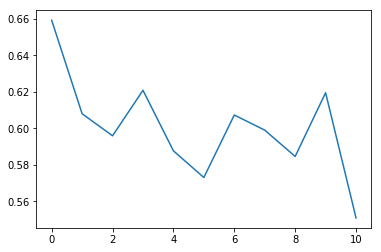

In [18]:
test=[]
for i in ress:
    temp=i.numpy()
    test.append(temp)
plt.plot(test)
plt.show()